<center><font size = "10"> Week 8 - Synapses <center>
<center><font size = "8">Home work - Solutions<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 1
<br>Group member1: Gasser Elbanna
<br>Group member2: Milo Imbeni
<br>Group member3: Louise Placidet

In [1]:
!nrnivmodl

/home/In Silico/Week 8
SimpleAMPA_NMDA.mod TsodyksMarkram_AMPA_NMDA.mod vecevent.mod
SimpleAMPA_NMDA.mod TsodyksMarkram_AMPA_NMDA.mod vecevent.mod
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=link gcc -module  -g -O2    -o libnrnmech.la -rpath "/usr/local/nrn/x86_64/lib"  SimpleAMPA_NMDA.lo TsodyksMarkram_AMPA_NMDA.lo vecevent.lo mod_func.lo  -L"/usr/local/nrn/x86_64/lib" -lnrnoc -loc -lmemacs  -lscopmath -lsparse13 -lreadline -lncurses -ltinfo -L"/usr/local/nrn/x86_64/lib" -lnrniv -livoc -lneuron_gnu -lmeschach -lsundials       -lm -ldl
libtool: link: rm -fr  .libs/libnrnmech.la .libs/libnrnmech.lai .libs/libnrnmech.so .libs/libnrnmech

# Ex1. Plot the dependence of the NMDA conductance on Mg<sup>2+</sup>.

<font sie='3'>Create a single compartmental soma neuron to host the synpase modeled in SimpleAMPA_NMDA.mod file. Using the stimulation pattern and the values for the peak synaptic conductances used in tutorial 01, plot the NMDA conductance after removing the magnesium block, without changing the Mg<sup>2+</sup> concentration. Show how the NMDA conductance changes as the magnesium block is gradually removed.
    
<font sie='3'>Explain what happens to the NMDA conductance and why, in a mechanistic sense, does this happen. What could be the functional purpose of this behavior? [1.5 pts]

### --> Increasing the stimualtion frequency

The magnesium block of the NMDA receptors is present when the membrane potential is at resting potential.  In order to remove this magnesium block, without changing the $Mg^{2+}$ concentration, means that we have to depolarize the cell enough.  For this depolarization to happen, the soma needs to be stimulated enough for its membrane potential to be increased.  This can be done by increating the stimulation frequency.  Indeed, let's plot the NMDA conductance when this stimulation frequency is progressively increased:

##### Creating a single compartmental soma neuron and hosting the synapse modeled in SimpleAMPA_NMDA.mod file:

In [6]:
#Import packages
import neuron
from neuron import h
import numpy as np
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

# Load external files & initialize
h.load_file("stdrun.hoc");
h.stdinit();

In [7]:
# Build Soma compartment
soma = neuron.h.Section()
soma.L = 40
soma.diam = 40
soma.insert('pas')

# Configure the passive biophysics
for sec in h.allsec():
    sec.Ra = 100
    sec.cm = 1
    
# Create a synapse
synapse = h.SimpleAMPA_NMDA(soma(0.5))

##### Creating our different simulations with increasing firing frequency:

In [8]:
# Creating our simulations where we progressively increase the firing frequency
list_spike_times = []

for step in range(25, 1, -5):
    spike_times = np.arange(100, 950, step)
    list_spike_times.append(spike_times)

list_spike_times.append(np.arange(100, 950, 1))

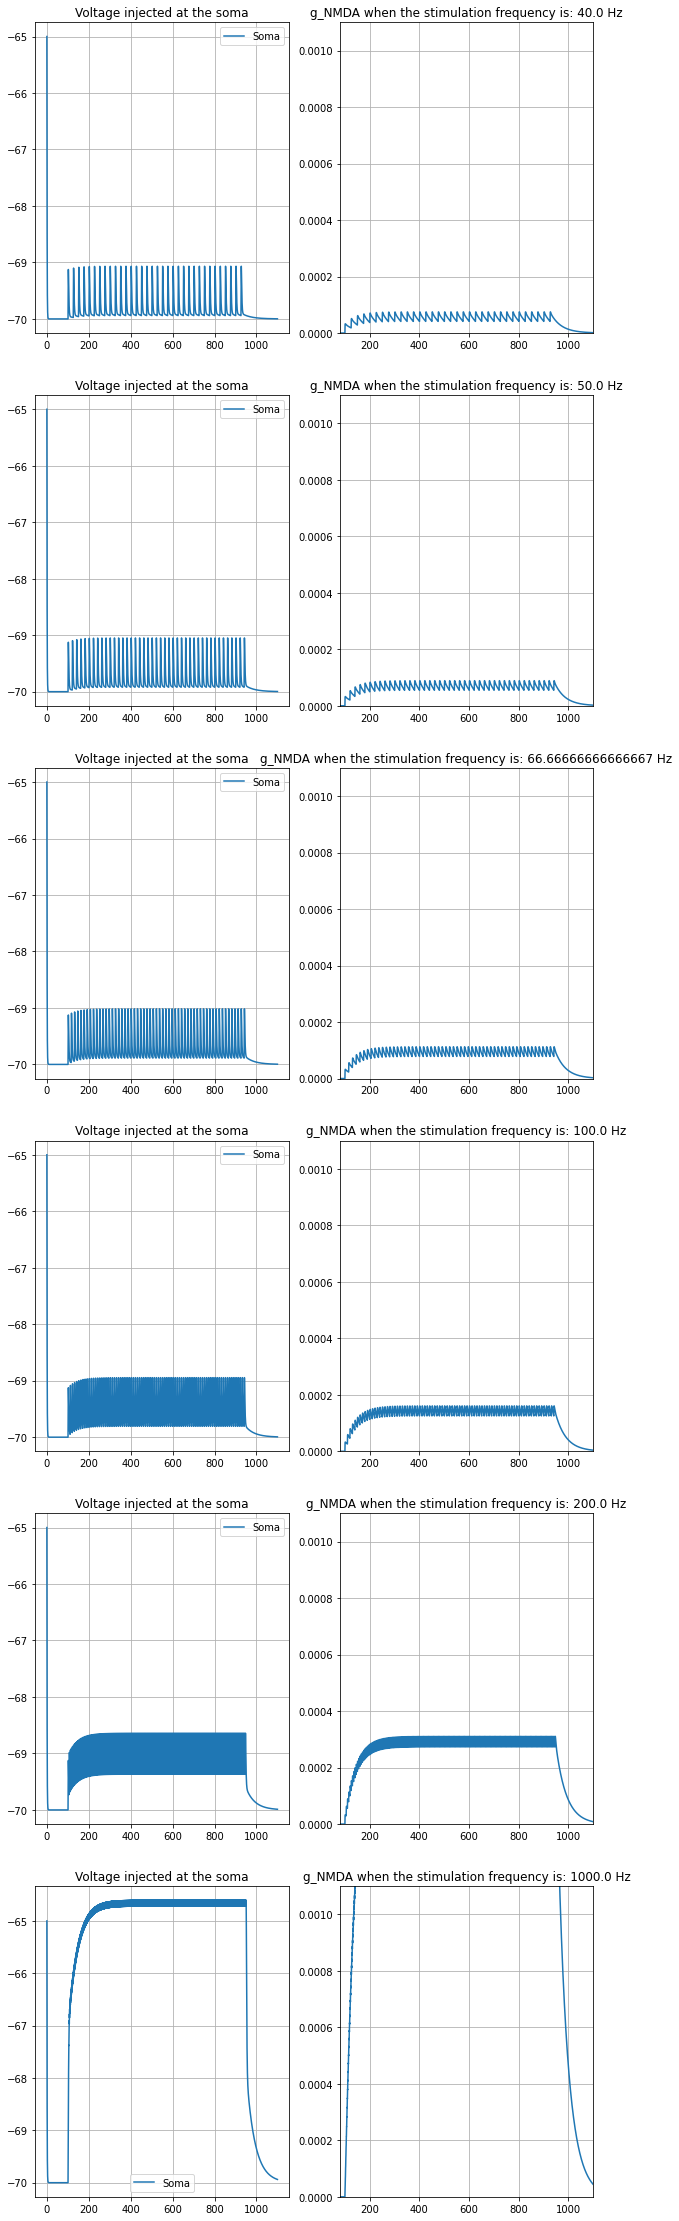

In [19]:
# Create Figure to include all subplots
fig = plt.figure(figsize=(10, 40))


for i, simulation in enumerate(list_spike_times):
    
    # Define stimulus, where we increase the amplitude to depolarize
    stimulator = h.VecStim()
    spike_times = simulation
    spikes_vector = h.Vector(spike_times)
    
    stimulator.play(spikes_vector)

    connection = h.NetCon(stimulator, synapse)
    connection.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file
    
    # Build Recording Electrodes
    g_syn = h.Vector()
    g_syn.record(synapse._ref_g)
    i_syn = h.Vector()
    i_syn.record(synapse._ref_i)
    v_soma = h.Vector()
    v_soma.record(soma(0.5)._ref_v)
    time = h.Vector()
    time.record(neuron.h._ref_t)

    # Set synapses conductances (AMPA & NMDA)
    synapse.gmax_AMPA = 0.001 # uS
    synapse.gmax_NMDA = 0.7 * 0.001 # uS - 0.7 is a biologically typical ratio of NMDA to AMPA conductance
    synapse.mg = 1 # mM
    g_NMDA = h.Vector()
    g_NMDA.record(synapse._ref_g_NMDA)
    g_AMPA = h.Vector()
    g_AMPA.record(synapse._ref_g_AMPA)

    h.tstop = 1100.0 # ms
    h.run();
    
    # Plot neuron in 3D in a subplot
    axes = fig.add_subplot(6, 2, 2*i+1)

    axes.plot(time, v_soma, label='Soma')
    axes.set_title("Voltage injected at the soma")
    axes.legend()
    axes.grid(True)
    
    axes = fig.add_subplot(6,2,2*i+2)
    
    axes.plot(time, g_NMDA, label= 'g_NMDA')
    Title = "g_NMDA when the stimulation frequency is: "+str((1/(simulation[3]-simulation[2]))*1e3)+" Hz"
    axes.set_title(Title)
    axes.axis([80.0, 1100.0, 0.0, 0.0011])
    axes.grid(True)
    

### --> What happens to the NMDA conductance and why, in a mechanistic sense, does this happen? What could be the functional purpose of this behavior?

Current flow through NMDAR channels is largely blocked by external Mg2+ ions at resting membrane potentials, but can be relieved by depolarization.  Indeed, when the NMDA channels are depolarized, the magnesium is expelled form the ion channel pore, and this channel can contribute to long-lasting EPSC.

NMDARs receptors play a key role in the induction of many forms of synaptic plasticity. Indeed, according to ["Kinetics of Mg2+ unblock of NMDA receptors: implications for spike-timing dependent synaptic plasticity"](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1664940/), as NMDARs are largely blocked by Mg2+ at resting membrane potentials, the kinetics of Mg2+ unblock of NMDAR channels will influence NMDAR activation during synaptic plasticity induction. This is likely to be particularly important during spike-timing dependent plasticity (STDP), where the coincidence of EPSPs and action potentials (APs) within a brief time window determines the magnitude and sign of changes in synaptic strength.

# Ex2. Configure a pseudolinear synapse (E3)

<font size='3'> Create a single compartmental soma neuron, add to it passive properties, add to the center of the neuron a synapse with the mechanism modeled in TsodyksMarkram_AMPA_NMDA.mod file, inject a stimulation pattern and define the conductances for NMDA and AMPA receptors, as it was done in tutorial 02. 

<font size='3'>Find the values for U1, tau_rec and tau_facil that would make the synapse behave as a pseudolinear synapse and plot the R, Use and conductance curves.
    
<font size='3'>Define U1, tau_rec and tau_facil. Would you be able to define any relation between these variables depending on the synapse type? If yes, please explain. [1.5 pts]    

<span style="color:red"> Restart kernel out of precaution

### --> Creating a single compartment soma neuron, add passive properties, add synapse with mechanisms modeled in TsodyksMarkram_AMPA_NMDA.mod file

In [1]:
!nrnivmodl

/home/In Silico/Week 8
SimpleAMPA_NMDA.mod TsodyksMarkram_AMPA_NMDA.mod vecevent.mod
SimpleAMPA_NMDA.mod TsodyksMarkram_AMPA_NMDA.mod vecevent.mod
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=link gcc -module  -g -O2    -o libnrnmech.la -rpath "/usr/local/nrn/x86_64/lib"  SimpleAMPA_NMDA.lo TsodyksMarkram_AMPA_NMDA.lo vecevent.lo mod_func.lo  -L"/usr/local/nrn/x86_64/lib" -lnrnoc -loc -lmemacs  -lscopmath -lsparse13 -lreadline -lncurses -ltinfo -L"/usr/local/nrn/x86_64/lib" -lnrniv -livoc -lneuron_gnu -lmeschach -lsundials       -lm -ldl
libtool: link: rm -fr  .libs/libnrnmech.la .libs/libnrnmech.lai .libs/libnrnmech.so .libs/libnrnmech

In [5]:
# Importing libraries
import neuron
from neuron import h
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load external files & initialize
neuron.h.load_file("stdrun.hoc");
neuron.h.stdinit();

In [6]:
# Build Soma compartment
soma = neuron.h.Section()
soma.L = 40
soma.diam = 40
soma.insert('pas')

# Configure the passive biophysics
for sec in h.allsec():
    sec.Ra = 100
    sec.cm = 1
    
# Create a synapse
synapse = h.TsodyksMarkram_AMPA_NMDA(soma(0.5))

### --> Injecting a simulation pattern, and defining the conductances of AMPA and NMDA receptors:

In [7]:
# Define stimulus
stimulator = h.VecStim()
spike_fast = np.arange(100,950,5)
spike_times = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 950.0]
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

connection = h.NetCon(stimulator, synapse)
connection.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file

# Build Recording Electrodes
g_syn = h.Vector()
g_syn.record(synapse._ref_g)
i_syn = h.Vector()
i_syn.record(synapse._ref_i)
v_soma = h.Vector()
v_soma.record(soma(0.5)._ref_v)
time = h.Vector()
time.record(neuron.h._ref_t)
R_syn = h.Vector()
R_syn.record(synapse._ref_R)
Use_syn = h.Vector()
Use_syn.record(synapse._ref_Use)

# Let's configure biologically plausible values for the AMPA and NMDA model parameters
synapse.gmax_AMPA = 0.002 # uS
synapse.gmax_NMDA = 0.7 * 0.002 # uS - 0.7 is a biologically typical ratio of NMDA to AMPA conductance
synapse.mg = 1.0 # mM

### --> Now let's configure parameters to make the synapse behave as a pseudolinear synapse: 

Now let's configure the parameters to make the synapse behave as a pseudolinear synapse.  We have seen that there are two competitive phenomenons which compete and lead to either facilitation or depression: the intracellular calcium concentration and the number of vesicles which are ready to be fuse and release neurotransmitters in the synaptic cleft.

In the case of facilitation (E1), we have a higher fraction of opened calcium channels to be able to release more vesicles.  Indeed, when looking at the tutorial the recovery time from depression is much shorter than the relaxation time from facilitation.  On the other hand, for the case of depression (E2), we have a considerably higher recovery time from depression and a very small time for relaxation from facilitation.  

In order to configure the syanpse for it to behave like a pseudolinear synapse, we need to have a balance between depression and facilitation.  Indeed, the parameters need to be quite similar in order to produce a constant behavior:

In [8]:
synapse.U1 = 0.3 # Baseline release probability
synapse.tau_rec = 400 # ms - recovery from depression
synapse.tau_facil = 400 # ms - relaxation from facilitation

h.tstop = 1000.0 # ms
neuron.h.run();

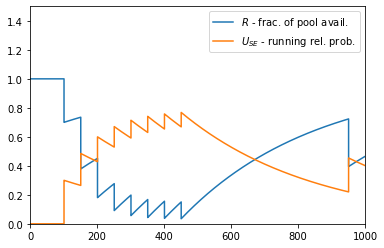

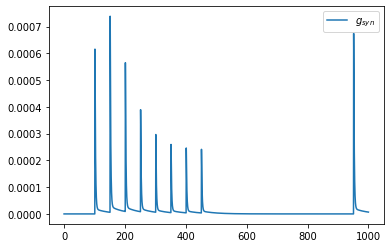

In [9]:
plt.figure()
plt.plot(time, R_syn, label='$R$ - frac. of pool avail.')
plt.plot(time, Use_syn, label='$U_{SE}$ - running rel. prob.')
plt.legend()
plt.axis([0,1000,0,1.5])

plt.figure()
plt.plot(time, g_syn, label="$g_{syn}$")
plt.legend()

### --> Define U1, tau_rec and tau_facil. Would you be able to define any relation between these variables depending on the synapse type? If yes, please explain.

Let's define the terms:

- U1: in the orignal Tsodyk and Markram's original model, this was considered as a constant, and is defined as the percentage of available resources which are released when an AP occurs.  However, in the TM model which takes into account facilitation, this U1 is no longer constant, but evolves according to a first-order differential equation, and changes according to a facilitation factor.  It now takes into account whether the use of transmitter goes up or down every time there is a spike, thus considering the intracellular flow of $Ca^{2+}$ (facilitation) and the extracellular flow of $Ca^{2+}$ due to an AP

- tau_rec: this constant considers how long it takes until the synapse is as strong as before the first AP arrived (its value is $\approx 100 ms$)

- tau_facil: this constant considers how long it takes to inactivate hte used resources (its value is $\approx 1 ms$)

According to ["Differential depression at excitatory and inhibitory synapses in visual cortex"](https://pubmed.ncbi.nlm.nih.gov/10341233/), it is possible to identify a relation between the variables depending on synapse type.  Indeed, they compared the dynamics of synaptic transmission at excitatory and inhibitory synapses of the visual cortical pyramidal neurons.  They noted that inhibitory synapes showed less overall depression than excitatory synapses and that the kinetics of recovery from depression also differ between the two classes of synapse.

# Ex 3. Ornstein-Uhlenbeck Process

<font size='3'> Based on the data from one of the connections in your group folder (.h5 files), calculate the parameters required for an Ornstein-Uhlenbeck process, and plot their distributions as shown in [Barros-Zulaica et al., 2019](https://www.ncbi.nlm.nih.gov/pubmed/31680928). Note that you don't need to plot the smoothed histogram overlay shown in the paper [1.5 pts]


<span style="color:red"> Restart kernel out of precaution

### --> Loading the data and plotting the traces:

In [262]:
#Import packages
import neuron
from neuron import h
import numpy as np
import matplotlib.pyplot as plt
import h5py
#from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit

%matplotlib inline

In [263]:
data1 = h5py.File('connection_c1.h5', 'r')
data2 = h5py.File('connection_c2.h5', 'r')
data3 = h5py.File('connection_c4.h5', 'r')

print("data 1:")
print(data1.keys())
print("data 2:")
print(data2.keys())
print("data 3:")
print(data3.keys())

data 1:
<KeysViewHDF5 ['v0', 'v1', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v2', 'v20', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']>
data 2:
<KeysViewHDF5 ['v0', 'v1', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v2', 'v20', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']>
data 3:
<KeysViewHDF5 ['v0', 'v1', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v2', 'v20', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']>


In [264]:
# Let's consider one of our connections:

data = data1

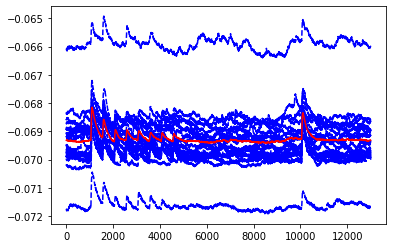

In [265]:
# Create an array with the data

connection_array = []
for v in data.keys():
    dat = data.get(v)
    dat = np.array(dat)
    connection_array.append(dat)

mean_trace = np.mean(connection_array, axis = 0)

plt.figure()
for rep in connection_array:
    plt.plot(rep, 'b--')
plt.plot(mean_trace, 'r')

### --> Computing the parameters required for an Ornstein-Uhlenbeck process

According to [Barros-Zulaica et al., 2019](https://www.ncbi.nlm.nih.gov/pubmed/31680928), implementing an Ornstein-Uhlenbeck process (OU-process), which is a stochastic process, allowed to simulate small random variability.

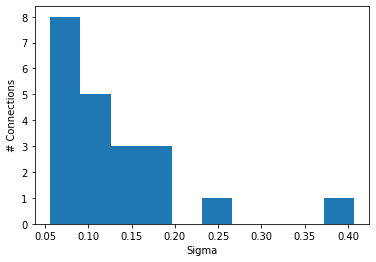

In [266]:
standard_deviation = []

for rep in connection_array:
    # Considering 400 ms segment used to compute the parameters for noise calibration
    rep = rep[6000:10000]
    
    # Computing the standard deviation:
    sd = np.std(rep)*1e3
    standard_deviation.append(sd)


plt.figure()
plt.xlabel("Sigma")
plt.ylabel("# Connections")
plt.hist(standard_deviation, bins=10);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


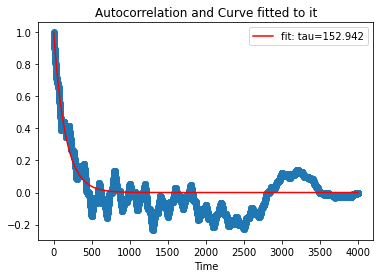

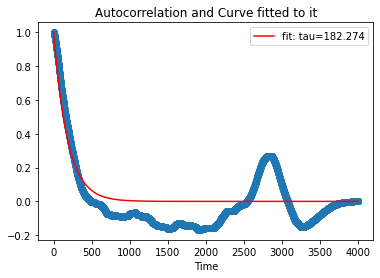

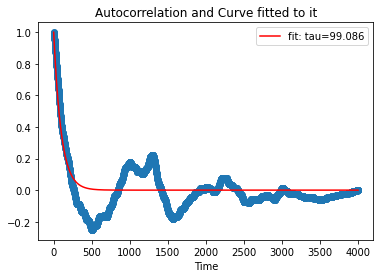

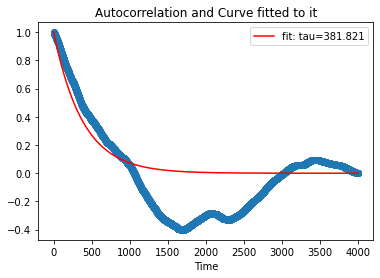

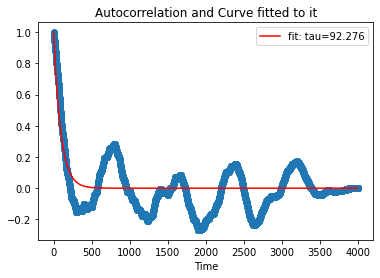

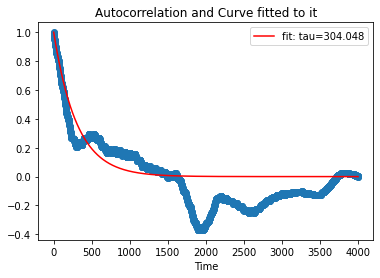

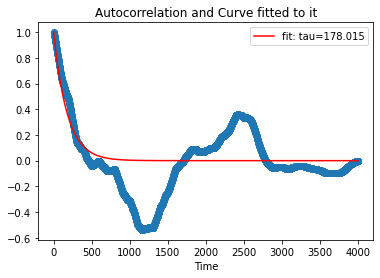

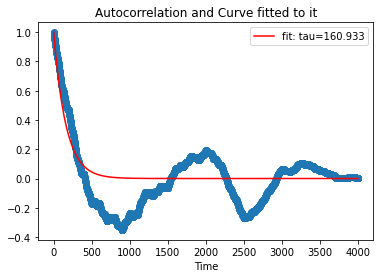

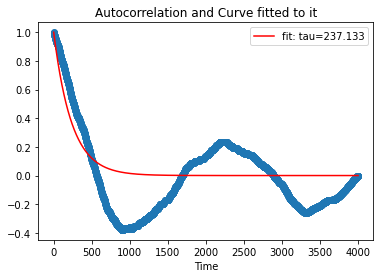

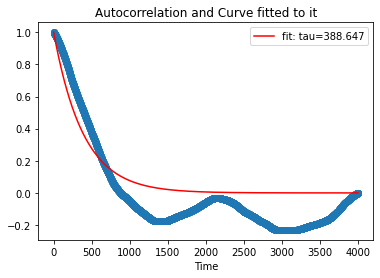

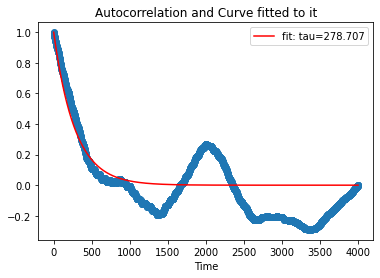

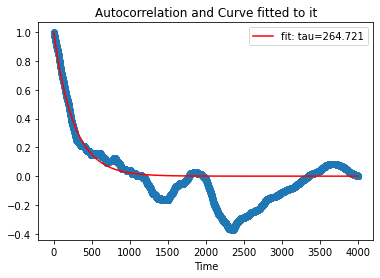

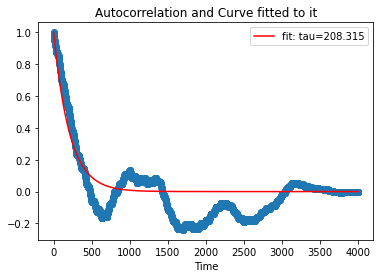

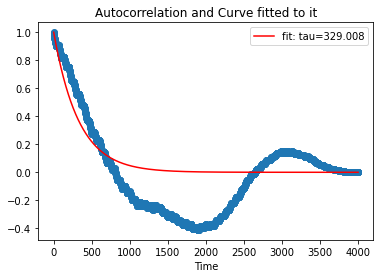

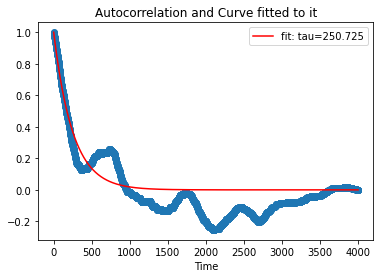

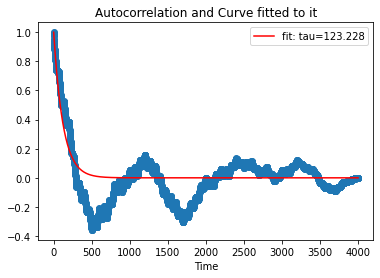

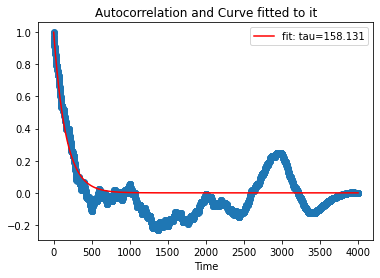

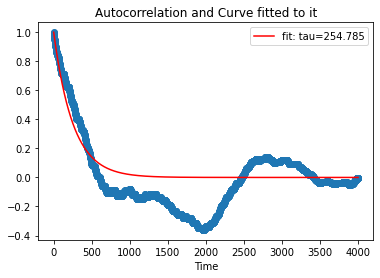

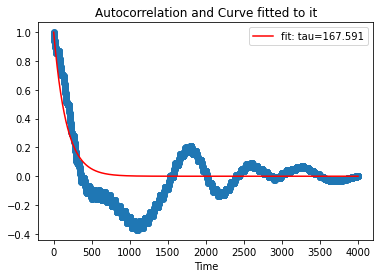

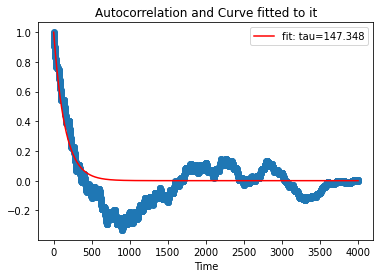

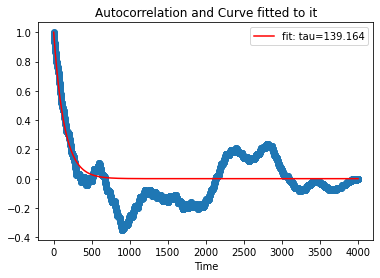

In [267]:
tau_values = []

def func_exp(x, tau):
    return np.exp(-x/tau)

for rep in connection_array:
    # Considering 400 ms segment used to compute the parameters for noise calibration
    rep = rep[6000:10000]
    
    # Autocorrelating our signal:
    rep_autocorrelated = acf(rep, nlags = 4000, fft=True)
    
    #plt.figure()
    #plt.plot(rep_autocorrelated)
    
    # Fitting exponential curve to it
    popt, pcov = curve_fit(func_exp, np.arange(0,4000), rep_autocorrelated)
    
    plt.figure()
    plt.xlabel("Time")
    plt.title('Autocorrelation and Curve fitted to it')
    plt.scatter(np.arange(0,4000), rep_autocorrelated)
    plt.plot(np.arange(0,4000), func_exp(np.arange(0,4000), popt[0]), '-r',label='fit: tau=%.3f' %(popt[0]))
    plt.legend()
    
    tau_values.append(popt[0]/10)

Text(0, 0.5, '# connections')

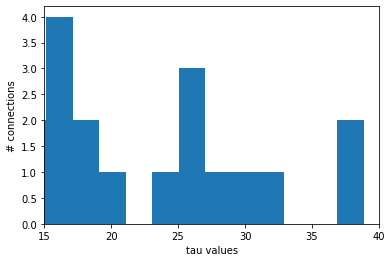

In [268]:
plt.figure()
plt.hist(tau_values, bins=15)
plt.xlim(15,40)
plt.xlabel('tau values')
plt.ylabel("# connections")

# Ex 4. Compute failure rate

<font size='3'>Compute the failure rate of the EPSPs from the connections of your group folder. The failure rate is the fraction of trials from which no PSP is generated above certain threshold. You can find a way of computing the failure rate in [Feldmeyer et al., 1999](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2269646/). Plot the mean failure rate for each of the three connections, as a function of the thresholds used in the definition of a failure. What does this tell you about your three different connections? [1.5 pts]

<span style="color:red"> Restart kernel out of precaution

In [41]:
#Import packages
import neuron
from neuron import h
import numpy as np
import matplotlib.pyplot as plt
import h5py
#from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import acf

%matplotlib inline 

According to Feldmeyer et al's article, they initially define specific windows.  These windows are then considered as measurements of the noise-contaminanted EPSP amplitude (A1, B1, A2 and B2).  In order to deduce the baseline noise, they compute the difference of potential amplitude between A2 and B2:
 $V_{baseline\_noise} = V_{A2} - V_{B2}$


 With this baseline noise, they then define failures as events with amplitude less than 1·5 × noise (and/or latencies larger than 2·5 × the mean latency).  In order to obtain the failure rate, they plotted the histogram of the amplitudes as a function of the sweep rate for the EPSP.  Using the previously defined threshold, they were able to identify the number of traces which had an amplitude below this threshold, over all of the traces.
 
 As a result, we will first be computing the threshold: by giving it all of the traces for one connection, computing the mean trace, and deducing from this trace, the baseline noise, and thus the threshold (1.5xbaseline noise).  We will then plot the distribution of EPSPs from the mean trace of a considered connection.  With the threshold, we will then compute the number of failed EPSP, as the number of EPSP from the distribution whose amplitude is below the threshold value out of all of the EPSPs.
 
We will computing the threshold for the 3 respective connections, and then deducing the mean failure rate.

<br><img src="Feldmeyer_figure.png" width="800" height="400">  

##### --> Computing baseline noise and threshold for mean connection

In [148]:
def amp_rise_lat_firstEPSP_noise_compute(sample_connection, STIM_TIMES, time, t_wind_bef, t_wind_aft, PLOT = False):
    """
    This function selects the rise curve (first EPSP) and find the  5, 20 and 80 % of the amplitude.
    Firstly computes the amplitude as the difference minimum - maximum in the interval (first_stimulus, max_peak).
    Secondly computes the percentages and find the times for these respective values.
    Tau_rise = 80%_time - 20%_time (Feldmeyer et al., 1999)
    latency = 5%_time - first_stimulus
    :param sample_connection: array with voltage traces oriented (voltage vs trials)(row vs column)
    :param STIM_TIMES: list with the stimuli points
    :param time: list with time steps in s
    :param t_wind_aft: time window after the stim time to compute max and min
    :param t_wind_bef: time window before the stim time to compute max and min
    :return amp_value: amplitude of the first EPSP computed as the difference between the 20 and the 80 % of rise
    :return TAU_rise: list with tau_rise values in ms. Computed as the distance between the times when
    the 20 and 80 % of the rise part for the first EPSP happens
    :return latency: list with latency values in ms. Computed as the time between the AP of the presynaptic cell
    and the 5% of the first EPSP
    """
    # The analysis are performed over the mean trace, in order to obtain an average threshold
    conn = np.mean(sample_connection, axis=0)

    # save only the trace part for the first peak for voltage and time
    rise_curve = conn[STIM_TIMES[0] - t_wind_bef:STIM_TIMES[0] + t_wind_aft]
    rise_curve_time = time[STIM_TIMES[0] - t_wind_bef:STIM_TIMES[0] + t_wind_aft]

    # find max, min and compute amplitude
    max_value = np.max(rise_curve)
    min_value = np.min(rise_curve)
    amp_value_total = np.abs(max_value - min_value)

    # compute percentages
    twenty_peak_value = amp_value_total * 80.0 / 100.0
    eighty_peak_value = amp_value_total * 20.0 / 100.0
    five_peak_value = amp_value_total * 95.0 / 100.0
    #zero_peak_value = amp_value_total* 100.0 / 100.0
    amp_value = eighty_peak_value - twenty_peak_value

    # Find the exact voltage point
    twenty_curve_value = -(twenty_peak_value - max_value)
    eighty_curve_value = -(eighty_peak_value - max_value)
    five_curve_value = -(five_peak_value - max_value)
    #zero_curve_value = -(zero_peak_value - max_value)

    # Find time point for the minimum
    for x, s in zip(rise_curve, rise_curve_time):
        if (x == min_value):
            min_time = s

    # Find time points for the 5, 20 and 80 % of the first EPSP
    n = 0
    m = 0
    l = 0
    
    for i, j in zip(rise_curve, rise_curve_time):
        if (n == 0) and (i > twenty_curve_value) and (j > min_time):
            twenty_time = j
            n = 1
        if (m == 0) and (i > eighty_curve_value) and (j > min_time):
            eighty_time = j
            m = 1
        if (l == 0) and (i > five_curve_value) and (j > min_time):
            five_time = j
            l = 1
    
    pre_AP = time[STIM_TIMES[0]]
    TAU_rise = np.abs((twenty_time-eighty_time))
    latency = np.abs((five_time)-pre_AP)
    
    five_time_index = int(five_time * 1e4)

    # Saving the trace from the position where the EPSP begins to 5ms before that
    A1_duration_index = int(5e-3 * 1e4)#5 ms

    A1 = conn[five_time_index-A1_duration_index : five_time_index] # Taking the position of the EPSP begin, defined as 5%
    A1_time = time[five_time_index-A1_duration_index : five_time_index]

    # Saving the trace for A2, which also lasts 5ms (as A1), and ends right when A1 begins
    A2 = conn[five_time_index - 2*A1_duration_index :five_time_index-A1_duration_index]
    A2_time = time[five_time_index - 2*A1_duration_index :five_time_index-A1_duration_index]
    
    # Saving the trace for B2, which is the window between the position of the AP peak, and the position of the beginning of the EPSP
    B2 = conn[STIM_TIMES[0]:five_time_index]
    B2_time = time[STIM_TIMES[0]:five_time_index]
    
    # PLOT first EPSP with the computed points for the 5, 20 and 80 % of the first EPSP
    if PLOT == True:
        plt.figure()
        plt.plot(rise_curve_time, rise_curve, label='first EPSP')
        plt.plot(A1_time, A1, label='A1')
        plt.plot(A2_time, A2, label='A2')
        plt.plot(B2_time, B2, label='B2')
        plt.plot(twenty_time, twenty_curve_value, 'ro', label='20%')
        plt.plot(eighty_time, eighty_curve_value, 'mo', label='80%')
        plt.plot(five_time, five_curve_value, 'go', label='5%')
        plt.legend()
        plt.show()
        
    V_baseline = np.abs(np.mean(A2)-np.mean(B2)) # Computing the baseline amplitude

    print("Baseline noise: "+str(V_baseline))
    return amp_value, TAU_rise, latency, V_baseline


Now that we have the function to compute the baseline noise for the mean of each connection, we can now compute the ranges of thresholds, by varying the scaling factor (1.5 initially) and multiplying it by the baseline noise.

In [149]:
# Load the data files (connections)

data1 = h5py.File('connection_c1.h5', 'r')
data2 = h5py.File('connection_c2.h5', 'r')
data3 = h5py.File('connection_c4.h5', 'r')

print("data 1:")
print(data1.keys())
print("data 2:")
print(data2.keys())
print("data 3:")
print(data3.keys())

data 1:
<KeysViewHDF5 ['v0', 'v1', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v2', 'v20', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']>
data 2:
<KeysViewHDF5 ['v0', 'v1', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v2', 'v20', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']>
data 3:
<KeysViewHDF5 ['v0', 'v1', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v2', 'v20', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']>


In [236]:
# Creating range of scaling factors that we want
scaling_factors = np.arange(0.5, 100.5, 0.5)
print(scaling_factors)

[  0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.
   6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.   11.5  12.
  12.5  13.   13.5  14.   14.5  15.   15.5  16.   16.5  17.   17.5  18.
  18.5  19.   19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5  24.
  24.5  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5  30.
  30.5  31.   31.5  32.   32.5  33.   33.5  34.   34.5  35.   35.5  36.
  36.5  37.   37.5  38.   38.5  39.   39.5  40.   40.5  41.   41.5  42.
  42.5  43.   43.5  44.   44.5  45.   45.5  46.   46.5  47.   47.5  48.
  48.5  49.   49.5  50.   50.5  51.   51.5  52.   52.5  53.   53.5  54.
  54.5  55.   55.5  56.   56.5  57.   57.5  58.   58.5  59.   59.5  60.
  60.5  61.   61.5  62.   62.5  63.   63.5  64.   64.5  65.   65.5  66.
  66.5  67.   67.5  68.   68.5  69.   69.5  70.   70.5  71.   71.5  72.
  72.5  73.   73.5  74.   74.5  75.   75.5  76.   76.5  77.   77.5  78.
  78.5  79.   79.5  80.   80.5  81.   81.5  82.   82.5  83.   83

In [237]:
# Computing the connection_arrays for the three connections

connection_array1 = []
for v in data1.keys():
    dat = data1.get(v)
    dat = np.array(dat)
    connection_array1.append(dat)

connection_array2 = []
for v in data2.keys():
    dat = data2.get(v)
    dat = np.array(dat)
    connection_array2.append(dat)

connection_array3 = []
for v in data3.keys():
    dat = data3.get(v)
    dat = np.array(dat)
    connection_array3.append(dat)

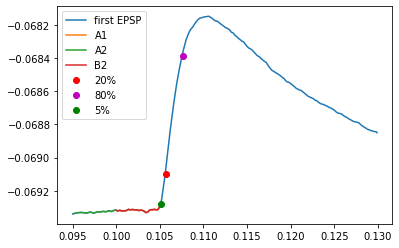

Baseline noise: 1.1121360193780405e-05


In [238]:
# Compute the basline noise for our three connections:

# times where a stimulus is performed
STIM_TIMES = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 10000]
t_wind_aft = 300
t_wind_bef = 50
time = np.arange(0,1.3,0.0001)


amp_value1, TAU_rise1, latency1, V_baseline1 = amp_rise_lat_firstEPSP_noise_compute(connection_array1, STIM_TIMES, time, t_wind_bef, t_wind_aft, PLOT = True)

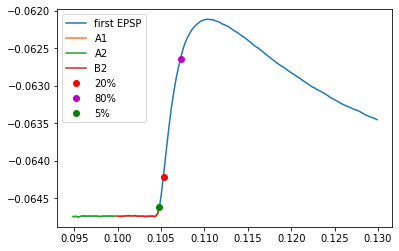

Baseline noise: 4.406034473367071e-06


In [239]:
amp_value2, TAU_rise2, latency2, V_baseline2 = amp_rise_lat_firstEPSP_noise_compute(connection_array2, STIM_TIMES, time, t_wind_bef, t_wind_aft, PLOT = True)

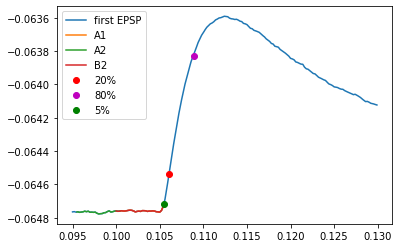

Baseline noise: 6.900724523514756e-06


In [240]:
amp_value3, TAU_rise3, latency3, V_baseline3 = amp_rise_lat_firstEPSP_noise_compute(connection_array3, STIM_TIMES, time, t_wind_bef, t_wind_aft, PLOT = True)

In [241]:
# Computing the ranges of thresholds for our three connections

thresholds_1 = scaling_factors*V_baseline1*1e4
thresholds_2 = scaling_factors*V_baseline2*1e4
thresholds_3 = scaling_factors*V_baseline3*1e4

print("Thresholds for connection 1: " +str(thresholds_1))
print("Thresholds for connection 2: " +str(thresholds_2))
print("Thresholds for connection 3: " +str(thresholds_3))

Thresholds for connection 1: [ 0.0556068   0.1112136   0.1668204   0.2224272   0.278034    0.33364081
  0.38924761  0.44485441  0.50046121  0.55606801  0.61167481  0.66728161
  0.72288841  0.77849521  0.83410201  0.88970882  0.94531562  1.00092242
  1.05652922  1.11213602  1.16774282  1.22334962  1.27895642  1.33456322
  1.39017002  1.44577683  1.50138363  1.55699043  1.61259723  1.66820403
  1.72381083  1.77941763  1.83502443  1.89063123  1.94623803  2.00184483
  2.05745164  2.11305844  2.16866524  2.22427204  2.27987884  2.33548564
  2.39109244  2.44669924  2.50230604  2.55791284  2.61351965  2.66912645
  2.72473325  2.78034005  2.83594685  2.89155365  2.94716045  3.00276725
  3.05837405  3.11398085  3.16958766  3.22519446  3.28080126  3.33640806
  3.39201486  3.44762166  3.50322846  3.55883526  3.61444206  3.67004886
  3.72565566  3.78126247  3.83686927  3.89247607  3.94808287  4.00368967
  4.05929647  4.11490327  4.17051007  4.22611687  4.28172367  4.33733048
  4.39293728  4.448544

We now have our respective thresholds for our three respective connections.  We can use them to compute the mean failed rate.  Indeed, we will be identifying for each threshold, the number of PSP which have an amplitude which is lower than that threshold.  This ratio of failed PSP out of the entire number of EPSPs will define our mean failure rate.

In [242]:
# Computing the amplitudes of all of the EPSPs
def compute_amplitude(mean_trace, STIM_TIMES, t_wind_bef, t_wind_aft):
    """
    This function compute the amplitudes of the EPSPs in mean_trace
    :param mean_trace: deconvelved voltage data 1D-array (list)
    :param STIM_TIMES: times where a stimulus is performed
    :param t_wind_bef: time window before the stimulus
    :param t_wind_aft: time window after the stimulus 
    :return amplitudes: list with amplitude values
    """
    amplitudes = []
    max_list = []
    min_list = []
    for t in STIM_TIMES:
        mx = np.max(mean_trace[(t-t_wind_bef):(t + t_wind_aft)])
        mn = np.min(mean_trace[(t-t_wind_bef):(t + t_wind_aft)])
        amp = np.abs(mx - mn) 
        max_list.append(mx*1000.0) # multiply by 1000.0 to convert values to mV
        min_list.append(mn*1000.0)
        amplitudes.append(amp*1000.0)
    return max_list, min_list, amplitudes


Text(0.5, 1.0, 'Histogram of EPSP amplitudes')

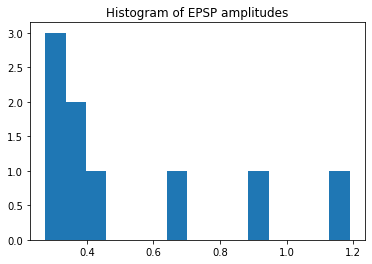

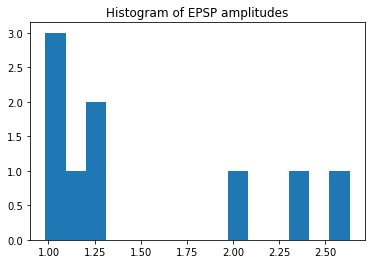

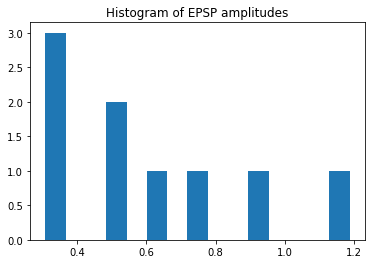

In [243]:
# Computing the mean traces for all 3 connections

mean_trace1 = np.mean(connection_array1, axis = 0)
mean_trace2 = np.mean(connection_array2, axis = 0)
mean_trace3 = np.mean(connection_array3, axis = 0)

# Computing the amplitudes for all three mean connections

_, _, amps1 = compute_amplitude(mean_trace1, STIM_TIMES, t_wind_bef, t_wind_aft)
_, _, amps2 = compute_amplitude(mean_trace2, STIM_TIMES, t_wind_bef, t_wind_aft)
_, _, amps3 = compute_amplitude(mean_trace3, STIM_TIMES, t_wind_bef, t_wind_aft)

# For illustration purposes, we can plot the histogram for our three connections:
plt.figure()
plt.hist(amps1, bins=15)
plt.title("Histogram of EPSP amplitudes")

plt.figure()
plt.hist(amps2, bins=15)
plt.title("Histogram of EPSP amplitudes")

plt.figure()
plt.hist(amps3, bins=15)
plt.title("Histogram of EPSP amplitudes")

In [251]:
# Identifying for each connection, the number of failed EPSPs

failed_list_1 = []
for thresh in thresholds_1:
    num_failed_epsp1 = len(np.where(amps1 <= thresh)[0])
    failed_list_1.append(num_failed_epsp1)

failure_rate1 = np.array(failed_list_1)/len(amps1) # Dividing the number of failed PSP by the total amount of EPSP


failed_list_2 = []
for thresh in thresholds_2:
    num_failed_epsp2 = len(np.where(amps2 <= thresh)[0])
    failed_list_2.append(num_failed_epsp2)
failure_rate2 = np.array(failed_list_2)/len(amps2) # Dividing the number of failed PSP by the total amount of EPSP


failed_list_3 = []
for thresh in thresholds_3:
    num_failed_epsp3 = len(np.where(amps3 <= thresh)[0])
    failed_list_3.append(num_failed_epsp3)
failure_rate3 = np.array(failed_list_3)/len(amps3) # Dividing the number of failed PSP by the total amount of EPSP

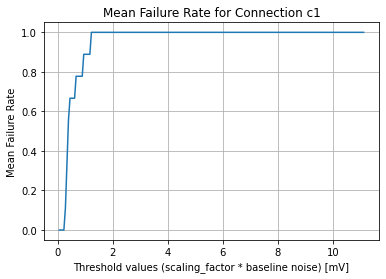

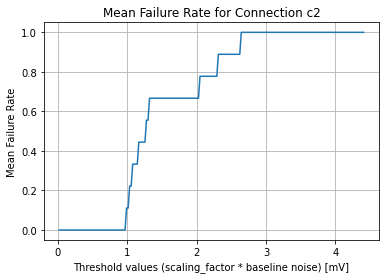

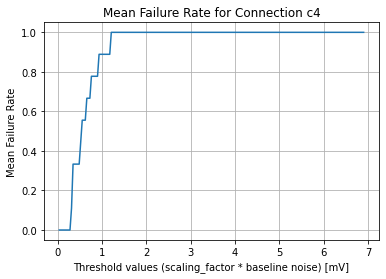

In [253]:
# Plotting the mean failure rate for each of the three connections

plt.figure()
plt.plot(thresholds_1, failure_rate1)
plt.title("Mean Failure Rate for Connection c1")
plt.xlabel("Threshold values (scaling_factor * baseline noise) [mV]")
plt.ylabel("Mean Failure Rate")
plt.grid(True)

plt.figure()
plt.plot(thresholds_2, failure_rate2)
plt.title("Mean Failure Rate for Connection c2")
plt.xlabel("Threshold values (scaling_factor * baseline noise) [mV]")
plt.ylabel("Mean Failure Rate")
plt.grid(True)

plt.figure()
plt.plot(thresholds_3, failure_rate3)
plt.title("Mean Failure Rate for Connection c4")
plt.xlabel("Threshold values (scaling_factor * baseline noise) [mV]")
plt.ylabel("Mean Failure Rate")
plt.grid(True)


When looking at the mean failure rates above, we notice that they eventually all converge to 1 when the scaling factor increases.  Indeed, as the threshold increases, more and more of the EPSPs will be considered as failed.

However, it is interesting to note among these three connections, that the mean failure rate for connection c1 and connection c4 is reached much faster than for connection c2.  This indicates for the second connection c2 has much higher EPSP amplitudes relative to the computed baseline noise.  On the other hand, the connections c1 and c4 have EPSP amplitudes relative to their baseline noise which are considerably lower and thus considered as failed faster.